**This notebook contain my second attempt on exploring and predicting surviving passengers using the Titanic dataset. This is a commom dataset for studying and learning on how to explore and analyze datasets as well as to build Machine Learning models. In this second attempt I will try to enhance my earlier model exploring more possibilities on using the dataset and the data available, like for example working with the features that were not used in the previous attempt (like name, ticket and cabin).**

# Exercise 3 - Tackle the Titanic dataset - Attempt 2

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [78]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import os
import tarfile
import urllib
import joblib
import itertools
import re
from scipy import stats
from packaging import version
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import loguniform, expon
from sklearn import set_config

set_config(transform_output='pandas')

sns.set_theme(style="whitegrid")
sns.set(font_scale = 1)

In [4]:
# Code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path()  / 'handson_ml3' / "my_folder" / "images" / "titanic"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# Local variables
LOCAL_PATH = "handson_ml3/my_folder/"
TITANIC_PATH = os.path.join("datasets" , "titanic")
TITANIC_URL = "https://github.com/ageron/data/raw/main/titanic.tgz"

def download_titanic_data(titanic_url=TITANIC_URL, titanic_path=TITANIC_PATH, local_path=LOCAL_PATH):
    """Download the titanic data and extract it to a csv"""
    if not os.path.isdir(local_path + titanic_path):
        os.makedirs(local_path + titanic_path)
    tgz_path = os.path.join(local_path + titanic_path, "titanic.tgz")
    urllib.request.urlretrieve(titanic_url, tgz_path)
    titanic_tgz = tarfile.open(tgz_path)
    titanic_tgz.extractall(path=local_path + "datasets")
    titanic_tgz.close()
    return pd.read_csv(local_path + titanic_path + '/train.csv'), pd.read_csv(local_path + titanic_path + '/test.csv') 

In [6]:
train_data, test_data = download_titanic_data()

In [7]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [9]:
train_data['PassengerId'].nunique()

891

We can see that the column "Age" has 177 null values while "Cabin" column has almost all of it's entries as null values. The other columns has no null values.

The "PassengerId" column is just a unique identifier for each passenger and we can drop it or set it as the index for the dataset.

In [10]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [11]:
train_data_copy = train_data.copy()

Let us see some histogramas

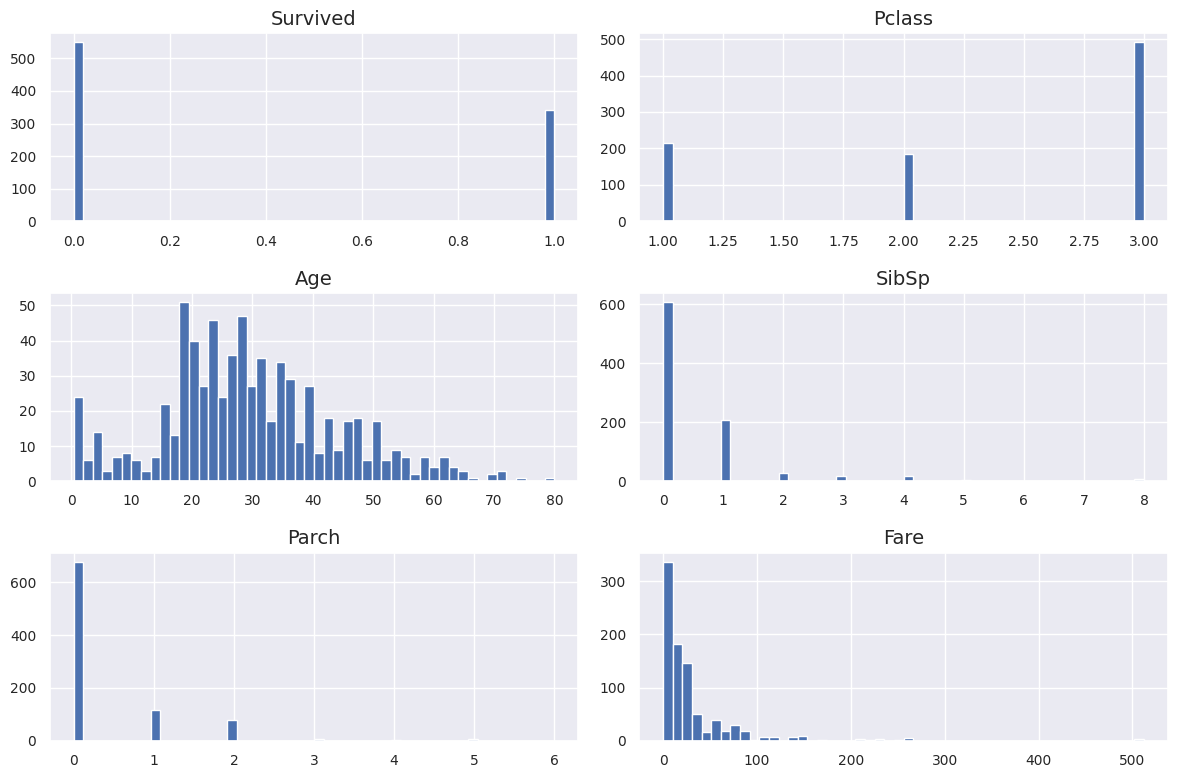

In [12]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_data_copy.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()

In [13]:
train_data_copy['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [14]:
median_age_by_class = train_data_copy.groupby('Pclass')['Age'].median().reset_index()
median_age_by_class.columns = ['Pclass', 'median_age']
median_age_by_class

,Pclass,median_age
0,1,37.0
1,2,29.0
2,3,24.0


In [15]:
for index, row in median_age_by_class.iterrows():
    class_value = row['Pclass']
    median_age = row['median_age']
    train_data_copy.loc[train_data_copy['Pclass'] == class_value, 'Age'] = train_data_copy.loc[train_data_copy['Pclass'] == class_value, 'Age'].fillna(median_age)

train_data_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S


In [16]:
train_data_copy['Cabin'].nunique()

147

In [17]:
train_data_copy['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [18]:
train_data_copy['Cabin'].value_counts(dropna=False)

Cabin
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

Let us explore the Cabin column:

In [19]:
# Function to extract the first letter using regex
def extract_first_letter(cabin):
    pattern = r'^([A-Z])'
    if isinstance(cabin, str):
        match = re.match(pattern, cabin)
        if match:
            return match.group(1)
    return None

# Apply the function to create a new column 'Cabin_First_Letter'
train_data_copy['Cabin_First_Letter'] = train_data_copy['Cabin'].apply(extract_first_letter)

train_data_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_First_Letter
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,None
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,None
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,None
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,None
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S,None


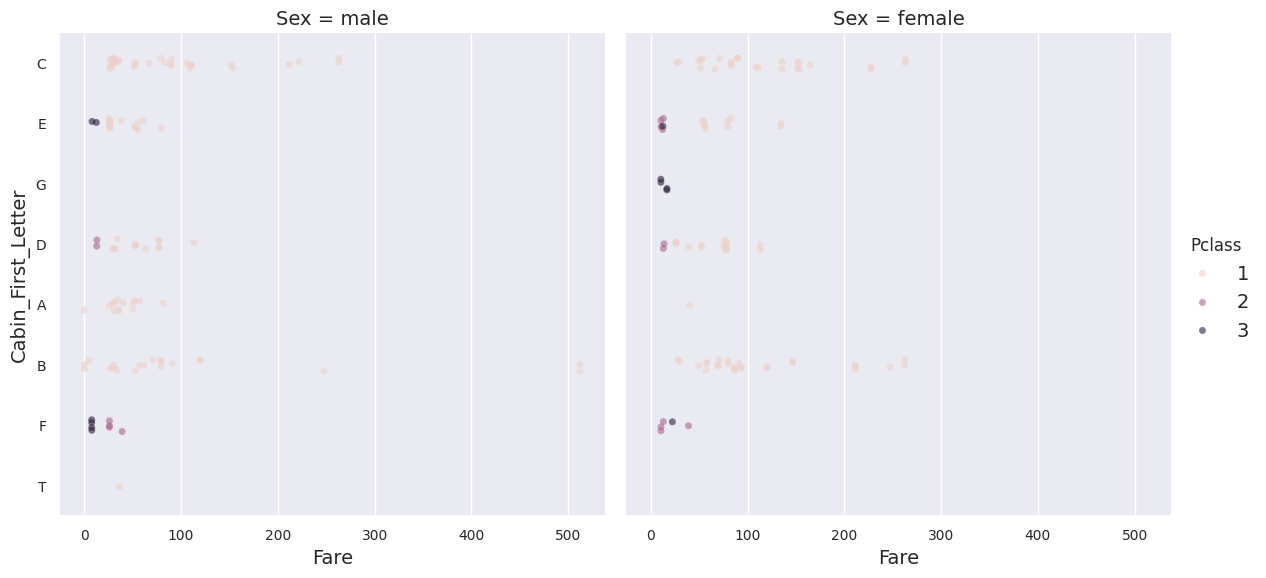

In [20]:
g = sns.catplot(data= train_data_copy,
                x= 'Fare',
                y= 'Cabin_First_Letter',
                col= 'Sex',
                hue='Pclass',
                alpha=.6, height=6
               )
g.despine(left=True)

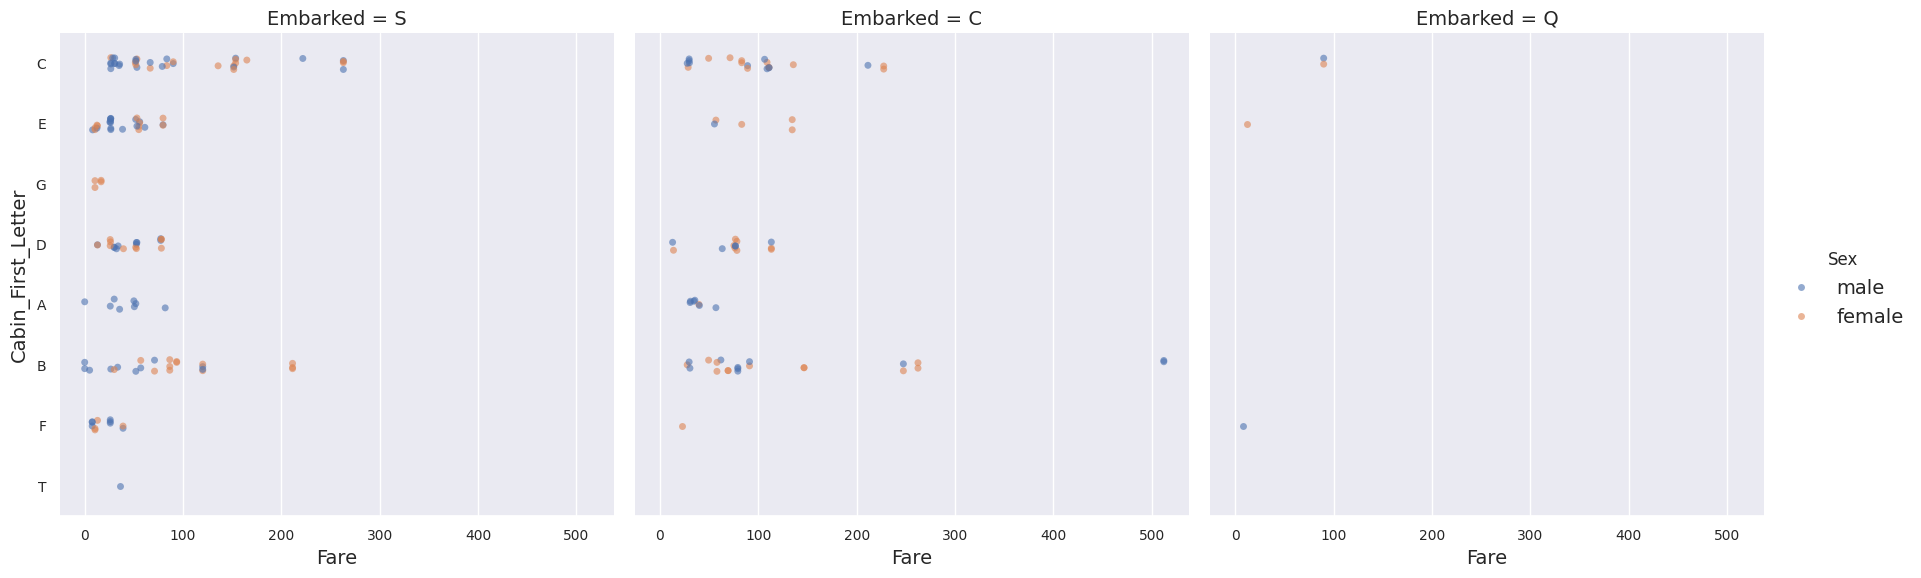

In [21]:
g = sns.catplot(data= train_data_copy,
                x= 'Fare',
                y= 'Cabin_First_Letter',
                col= 'Embarked',
                hue='Sex',
                alpha=.6, height=6
               )
g.despine(left=True)

Let us see what is the median fare for each letter in the Cabin_First_Letter column:

In [22]:
median_fare_by_cabin = train_data_copy.groupby('Cabin_First_Letter')['Fare'].median().reset_index()
median_fare_by_cabin.columns = ['Cabin_First_Letter', 'median_fare']
median_fare_by_cabin

,Cabin_First_Letter,median_fare
0,A,35.50000
1,B,80.00000
2,C,83.47500
3,D,53.10000
4,E,45.18125
5,F,13.00000
6,G,13.58125
7,T,35.50000


We can fill the NaN values of the column "Cabin_First_Letter" based on how close the Fare is to each median_fare value: we calculate the distance between Fare and all possible median_fare and fill the NaN value for the Cabin Letter based on the smallest distance:

In [24]:
# Function to fill NaN values in 'Cabin_letter' column
def fill_cabin_letter(row):
    if pd.isnull(row['Cabin_First_Letter']):
        # Calculate absolute differences between fare and median fares for each cabin letter
        differences = median_fare_by_cabin.set_index('Cabin_First_Letter')['median_fare'] - row['Fare']
        # Find the cabin letter with the smallest absolute difference
        closest_cabin = differences.abs().idxmin()
        return closest_cabin
    else:
        return row['Cabin_First_Letter']

train_data_copy['Cabin_First_Letter'] = train_data_copy.apply(fill_cabin_letter, axis=1)
train_data_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_First_Letter
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,F
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,F
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,F
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,F
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S,G


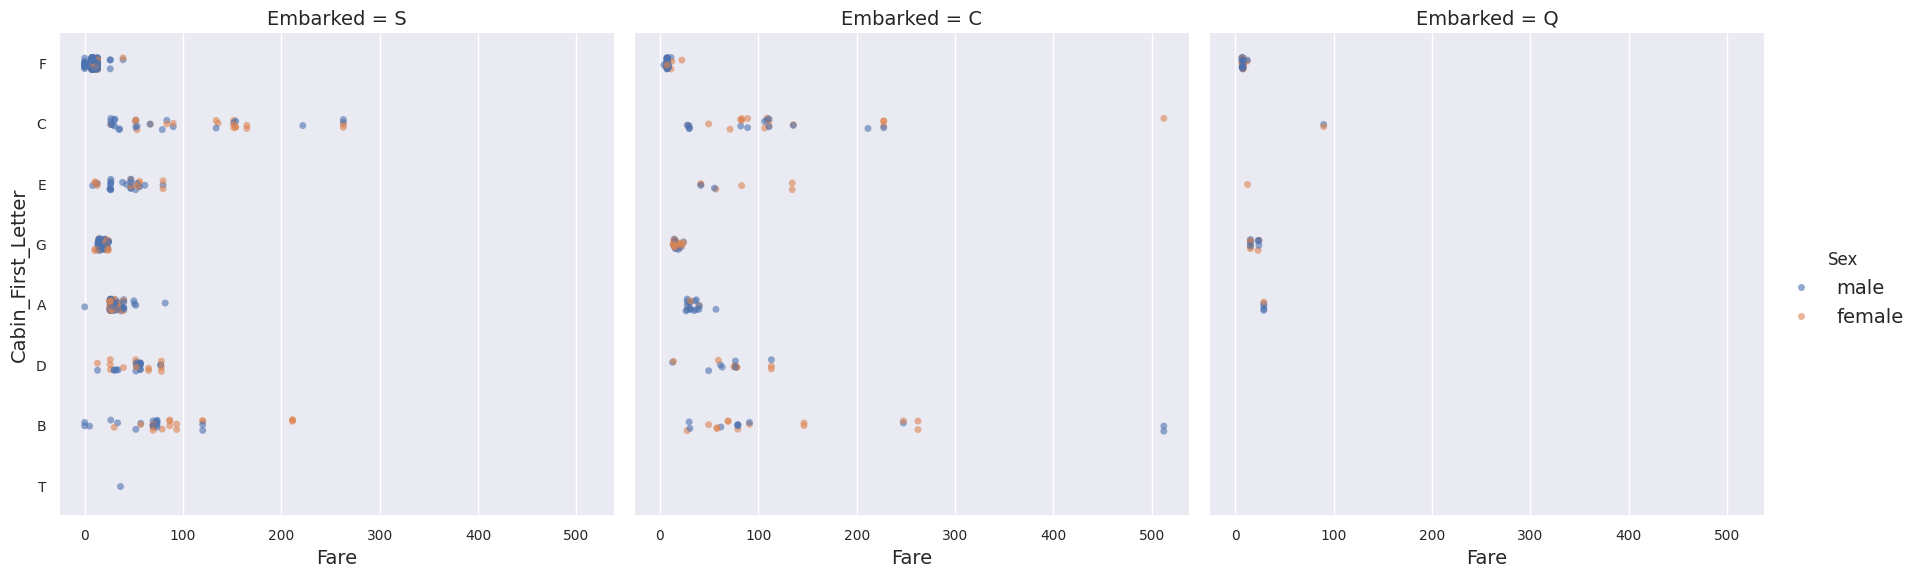

In [25]:
g = sns.catplot(data= train_data_copy,
                x= 'Fare',
                y= 'Cabin_First_Letter',
                col= 'Embarked',
                hue='Sex',
                alpha=.6, height=6
               )
g.despine(left=True)

In [26]:
train_data_copy['total_relatives'] = train_data_copy['Parch'] + train_data_copy['SibSp']

In [27]:
train_data_copy['total_relatives'].value_counts()

total_relatives
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64

In [28]:
# Create a pivot table to count the number of survivors for each total number of relatives
survival_df = pd.pivot_table(train_data_copy, index='total_relatives', columns='Survived', aggfunc='size', fill_value=0)

# Add a column for the total number of passengers for each total number of relatives
survival_df['total_passengers'] = survival_df.sum(axis=1)

# Calculate the percentage of survivors for each total number of relatives
survival_df['survival_percentage'] = (survival_df[1] / survival_df['total_passengers']) * 100

# Rename the index and reset it to make it cleaner
survival_df.index.name = 'Total Relatives'
survival_df.reset_index(inplace=True)
survival_df

Survived,Total Relatives,0,1,total_passengers,survival_percentage
0,0,374,163,537,30.353818
1,1,72,89,161,55.279503
2,2,43,59,102,57.843137
3,3,8,21,29,72.413793
4,4,12,3,15,20.000000
5,5,19,3,22,13.636364
6,6,8,4,12,33.333333
7,7,6,0,6,0.000000
8,10,7,0,7,0.000000


In [29]:
conditions = [
    (train_data_copy['total_relatives'] == 0),
    (train_data_copy['total_relatives'] >= 1) & (train_data_copy['total_relatives'] <= 2),
    (train_data_copy['total_relatives'] == 3),
    (train_data_copy['total_relatives'] >= 4)
]
categories = ['A', 'B', 'C', 'D']

train_data_copy['traveling_category'] = np.select(conditions, categories, default='Unknown')
train_data_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_First_Letter,total_relatives,traveling_category
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,F,1,B
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1,B
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,F,0,A
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,1,B
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,F,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,F,0,A
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,0,A
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S,G,3,C


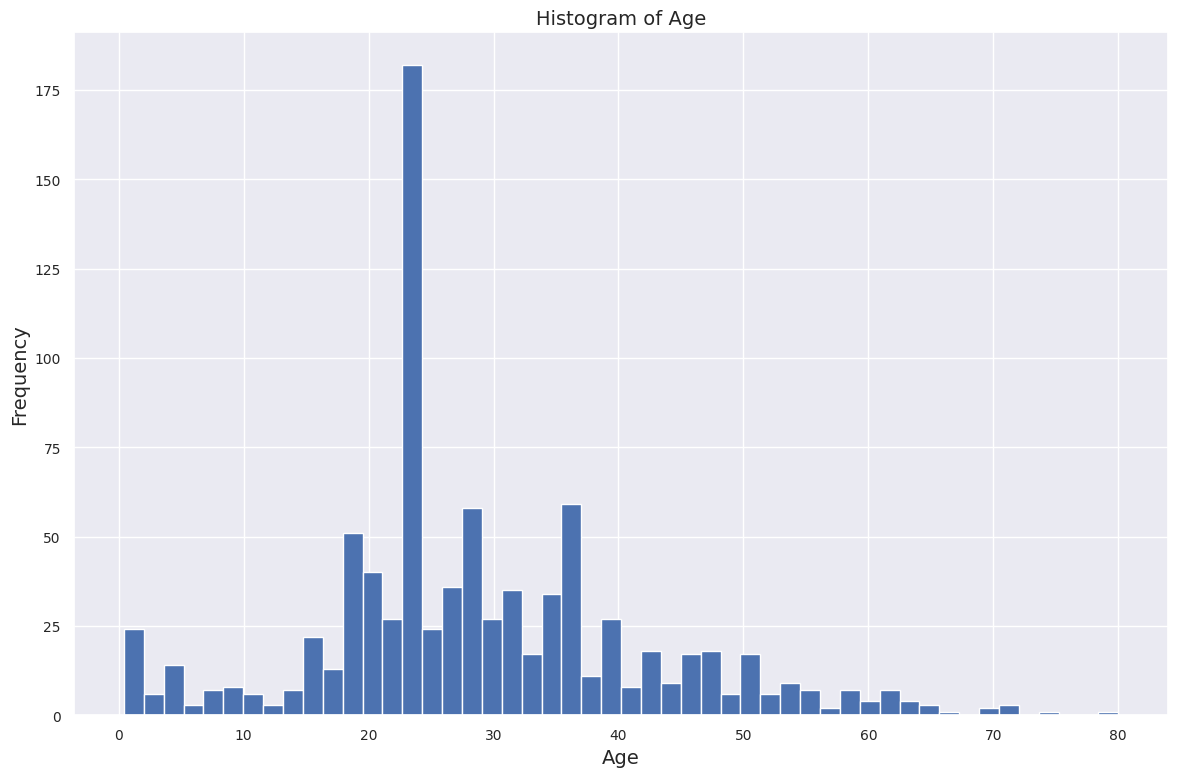

In [30]:
# Set font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Plot histogram for the 'Age' column
train_data_copy['Age'].hist(bins=50, figsize=(12, 8))
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
save_fig("age_histogram_plot")
plt.show()

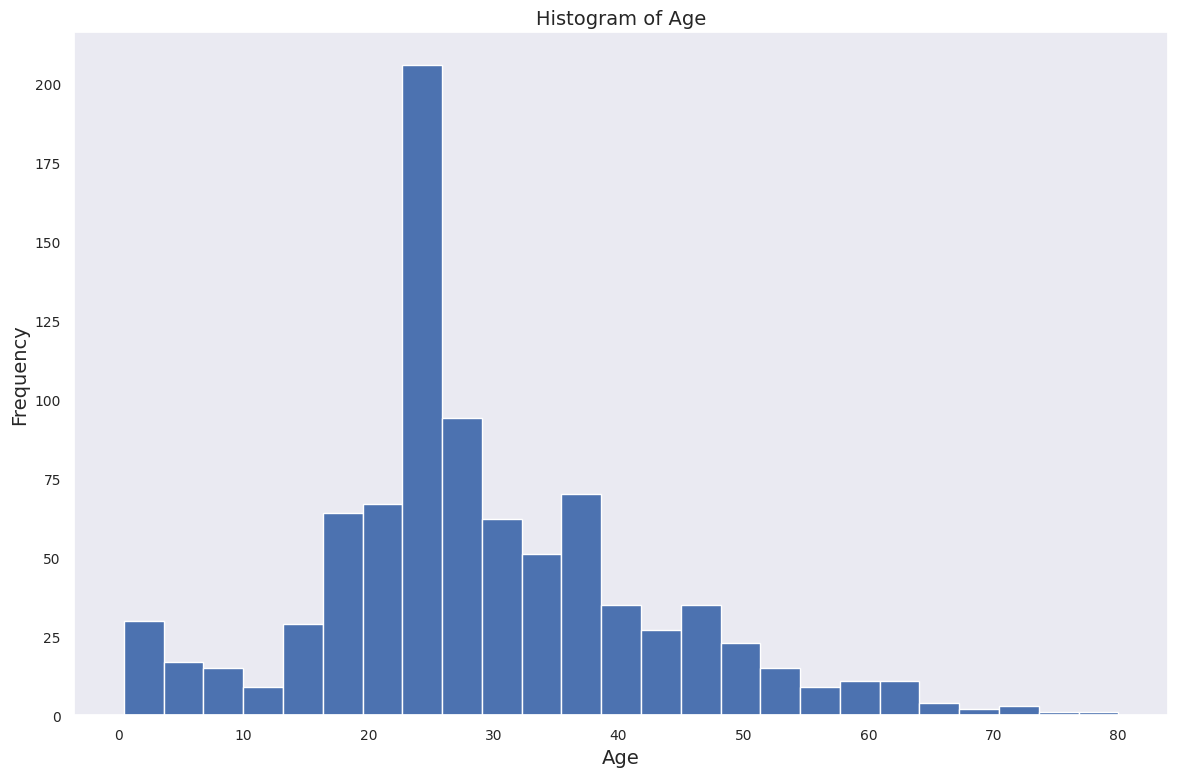

In [31]:
# Calculate Freedman-Diaconis bin width
iqr = np.percentile(train_data_copy['Age'].dropna(), 75) - np.percentile(train_data_copy['Age'].dropna(), 25)
bin_width = 2 * iqr / (len(train_data_copy['Age'].dropna()) ** (1/3))

# Determine number of bins based on data range and bin width
data_range = train_data_copy['Age'].max() - train_data_copy['Age'].min()
num_bins = int(data_range / bin_width)

# Plot histogram with Freedman-Diaconis bins
train_data_copy['Age'].hist(bins=num_bins, figsize=(12, 8))
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
save_fig("Freedman-Diaconis_Age_Bins")
plt.show()

In [32]:
bins = [0, 13, 22, 25, 35, 38, 54, 100]

train_data_copy['age_interval'] = pd.cut(train_data_copy['Age'], bins=bins)
train_data_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_First_Letter,total_relatives,traveling_category,age_interval
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,F,1,B,"(13, 22]"
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1,B,"(35, 38]"
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,F,0,A,"(25, 35]"
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,1,B,"(25, 35]"
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,F,0,A,"(25, 35]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,F,0,A,"(25, 35]"
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,0,A,"(13, 22]"
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S,G,3,C,"(22, 25]"


In [33]:
train_data_copy['age_interval'].value_counts()

age_interval
(25, 35]     207
(22, 25]     206
(13, 22]     160
(38, 54]     135
(0, 13]       71
(35, 38]      70
(54, 100]     42
Name: count, dtype: int64

In [35]:
# Create a pivot table to count the number of survivors for each age interval
survival_df = pd.pivot_table(train_data_copy, index='age_interval', columns='Survived', aggfunc='size', fill_value=0)

# Add a column for the total number of passengers for each age interval
survival_df['total_passengers'] = survival_df.sum(axis=1)

# Calculate the percentage of survivors for each age interval
survival_df['survival_percentage'] = (survival_df[1] / survival_df['total_passengers']) * 100

# Rename the index and reset it to make it cleaner
survival_df.index.name = 'Age_Interval'
survival_df.reset_index(inplace=True)
survival_df

Survived,Age_Interval,0,1,total_passengers,survival_percentage
0,"(0, 13]",29,42,71,59.154930
1,"(13, 22]",104,56,160,35.000000
2,"(22, 25]",146,60,206,29.126214
3,"(25, 35]",120,87,207,42.028986
4,"(35, 38]",39,31,70,44.285714
5,"(38, 54]",82,53,135,39.259259
6,"(54, 100]",29,13,42,30.952381


In [36]:
train_data_copy['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen 'Carrie'
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [37]:
# Regular expression pattern to extract Name's titles
pattern = r',\s*([A-Za-z]+)\.'

# Function to extract titles
def extract_title(name):
    match = re.search(pattern, name)
    if match:
        return match.group(1)
    else:
        return None  # or any other placeholder value

# Add 'Title' column to the DataFrame
train_data_copy['Title'] = train_data_copy['Name'].apply(extract_title)
train_data_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_First_Letter,total_relatives,traveling_category,age_interval,Title
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,F,1,B,"(13, 22]",Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1,B,"(35, 38]",Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,F,0,A,"(25, 35]",Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,1,B,"(25, 35]",Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,F,0,A,"(25, 35]",Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,F,0,A,"(25, 35]",Rev
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,0,A,"(13, 22]",Miss
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S,G,3,C,"(22, 25]",Miss


In [38]:
train_data_copy["Title"].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Ms            1
Lady          1
Sir           1
Capt          1
Jonkheer      1
Name: count, dtype: int64

## Cramer's V confusion Matrix

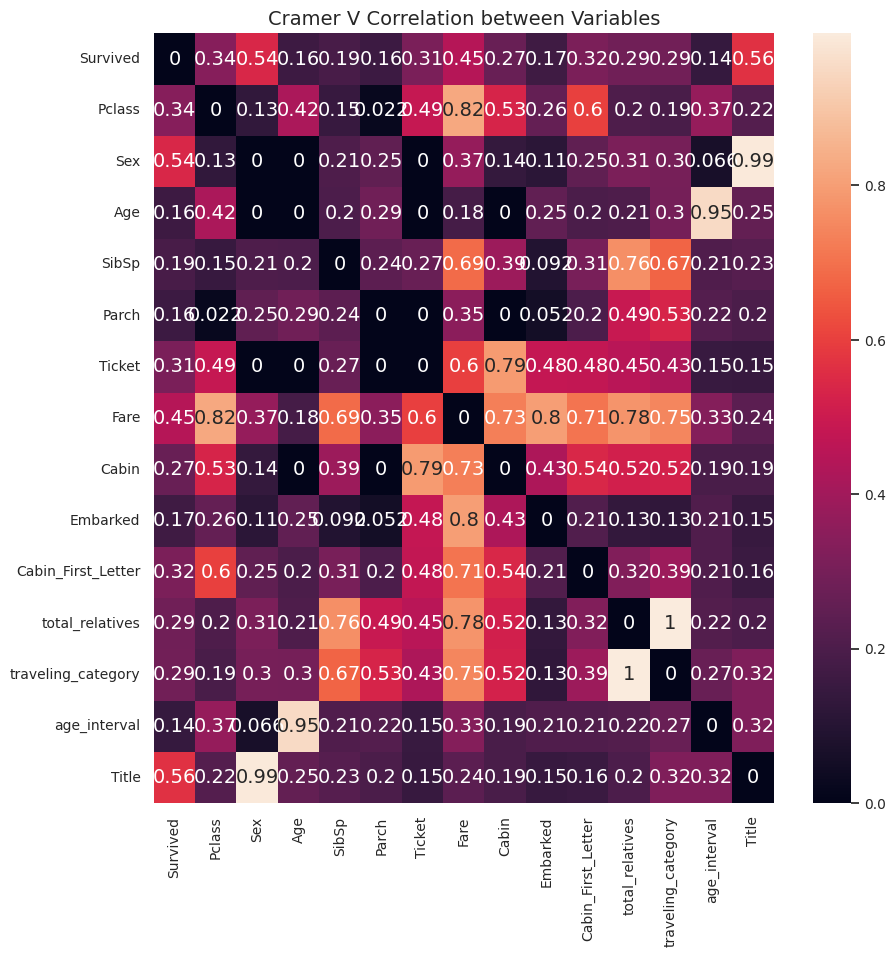

In [39]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = list(train_data_copy.columns.drop('Name'))

corr_matrix = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corr_matrix[idx1, idx2] = cramers_v(pd.crosstab(train_data_copy[col1], train_data_copy[col2]))
    corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

corr = pd.DataFrame(corr_matrix, index= cols, columns= cols)
fig, ax = plt.subplots(figsize= (10, 10))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

# Pipeline

In [42]:
titanic_data = train_data.drop("Survived", axis=1)
titanic_labels = train_data["Survived"].copy()

In [43]:
titanic_data

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


- Pclass: it will need to be ordinated with OrdinalEncoder. Class 1 > Class 2 > Class 3
- Name: We will extract the 'titles' for each name and OneHotEncode then
- Sex: OneHotEncoder
- Age: we will fill NaN values with the median per class and use it to create the age_interval column
- SibSp + Parch: we will sum it and use the total_relatives column
- Ticket: we will drop it for now
- Fare: we will use it with StandardScaler
- Cabin: we will extract the first letter indicating the Cabin and fill the NaN values with the closest distance from median fare
- Embarked: we will use it with OneHotEncoder
- total_relatives: we will use it to create traveling_category column based on how much relatives the passagen were traveling with
- traveling_category: we will use it with OneHotEncoder
- age_interval: we will use it with OneHotEncoder
- title: we will use it with OneHotEncoder
- Cabin_First_Letter: we will use it with OneHotEncoder

In [69]:
def sum_name(function_transformer, feature_names_in):
    return ["total_relatives"]  # feature names out

def sum_relatives(X):
    X_copy = X.copy()
    X_copy['total_relatives'] = X_copy['SibSp'] + X_copy['Parch']
    return X_copy[['total_relatives']]

total_relatives_pipeline = make_pipeline(
    FunctionTransformer(sum_relatives, feature_names_out=sum_name)
)

def cat_travel_name(function_transformer, feature_names_in):
    return ["traveling_category"]  # feature names out

def categorize_travel(X):
    X_copy = X.copy()
    
    conditions = [
        (X_copy['total_relatives'] == 0),
        (X_copy['total_relatives'] >= 1) & (X_copy['total_relatives'] <= 3),
        (X_copy['total_relatives'] >= 4)
    ]
    categories = ['A', 'B', 'C']

    X_copy['traveling_category'] = np.select(conditions, categories, default='Unknown')
    return X_copy[['traveling_category']]

travel_category_pipeline = make_pipeline(
    FunctionTransformer(categorize_travel, feature_names_out=cat_travel_name)
)

def cabin_letter_name(function_transformer, feature_names_in):
    return ["Cabin_First_Letter"]

def fill_cabin_letter(X):
    X_copy = X.copy()
    
    median_fare_by_cabin = X_copy.groupby('Cabin_First_Letter')['Fare'].median().reset_index()
    median_fare_by_cabin.columns = ['Cabin_First_Letter', 'median_fare']
    
    # Function to fill missing values in 'Cabin_First_Letter' column
    def fill_cabin(row):
        if pd.isnull(row['Cabin_First_Letter']):
            # Calculate absolute differences between fare and median fares for each cabin letter
            differences = median_fare_by_cabin.set_index('Cabin_First_Letter')['median_fare'] - row['Fare']
            # Find the cabin letter with the smallest absolute difference
            closest_cabin = differences.abs().idxmin()
            return closest_cabin
        else:
            return row['Cabin_First_Letter']
    
    X_copy['Cabin_First_Letter'] = X_copy.apply(fill_cabin, axis=1)
    return X_copy[['Cabin_First_Letter']]

filling_cabin_pipeline = make_pipeline(
	FunctionTransformer(fill_cabin_letter, feature_names_out=cabin_letter_name, kw_args={})
)

class_order = [[1, 2, 3]]

ord_pipeline = make_pipeline(
    OrdinalEncoder(categories=class_order)    
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    )

# Numerical for fare
fare_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

def drop_transformer(X):
    X_copy = X.copy()
    X_copy = X_copy.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    return X_copy

def drop_columns():
    return make_pipeline(
        FunctionTransformer(drop_transformer)
    )

def interval_name(function_transformer, feature_names_in):
    return ["age_interval"]  # feature names out

def age_transformer(X):
    X_copy = X.copy()
    median_age_by_class = X_copy.groupby('Pclass')['Age'].median().reset_index()
    median_age_by_class.columns = ['Pclass', 'median_age']
    for index, row in median_age_by_class.iterrows():
        class_value = row['Pclass']
        median_age = row['median_age']
        X_copy.loc[X_copy['Pclass'] == class_value, 'Age'] = \
            X_copy.loc[X_copy['Pclass'] == class_value, 'Age'].fillna(median_age)
    bins = [0, 13, 22, 25, 35, 38, 54, 100]
    labels = ['(0, 13]', '(13, 22]', '(22, 25]', '(25, 35]', '(35, 38]', '(38, 54]', '(54, 100]']
    X_copy['age_interval'] = pd.cut(X_copy['Age'], bins=bins, labels=labels)
    return X_copy[['age_interval']]

def age_processor():
    return make_pipeline(
        FunctionTransformer(age_transformer, feature_names_out=interval_name),
        )

def title_name(function_transformer, feature_names_in):
    return ["Title"]  # feature names out

def extract_title(X):
    X_copy = X.copy()
    pattern_title = r',\s*([A-Za-z]+)\.'
    X_copy['Title'] = X_copy['Name'].str.extract(pattern_title, expand=False)
    return X_copy[['Title']]
    
def name_processor():
	return make_pipeline(
		FunctionTransformer(extract_title, feature_names_out=title_name)
		)

def extract_first_letter(X):
    X_copy = X.copy()
    pattern_cabin = r'^([A-Z])'
    if isinstance(X_copy, pd.DataFrame):
        X_copy['Cabin_First_Letter'] = X_copy['Cabin'].str.extract(pattern_cabin)
        return X_copy[['Cabin_First_Letter']]
    return None

def cabin_processor():
	return make_pipeline(
		FunctionTransformer(extract_first_letter, feature_names_out=cabin_letter_name)
	)

# Defining the preprocessing steps
preprocessing_initial = ColumnTransformer([
		("name", name_processor(), ['Name']),
        ("ord", ord_pipeline, ['Pclass']),
        ("age_processing", age_processor(), ['Pclass', 'Age']),
		("cabin", cabin_processor(), ['Cabin']),
        ("num", fare_pipeline, ['Fare']),
        ("total_relatives", total_relatives_pipeline, ['SibSp', 'Parch'])],
        remainder='passthrough',
        verbose_feature_names_out=False
)

preprocessing_cabin_category = ColumnTransformer(
	[("cabin_filled", filling_cabin_pipeline, ['Cabin_First_Letter'])],
	remainder='passthrough',
	verbose_feature_names_out=False
)

preprocessing_travel_category = ColumnTransformer(
    [("travel_category", travel_category_pipeline, ['total_relatives'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

preprocessing_cat = ColumnTransformer(
    [("cat", cat_pipeline, ['Sex', 'Embarked', 'traveling_category', 'age_interval', 'Title', 'Cabin_First_Letter'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

class DropColumnsTransformer:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)
    
    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

# Define the columns you want to drop
#columns_to_drop = ['Name', 'Cabin', 'Ticket']
columns_to_drop = ['Ticket']

# Create a transformer to drop those columns
preprocessing_drop_columns = DropColumnsTransformer(columns=columns_to_drop)

# Combine all transformers in a pipeline
preprocessor = make_pipeline(
    preprocessing_initial,
    preprocessing_travel_category,
    preprocessing_cat,
    preprocessing_drop_columns  # Add the transformer to drop columns at the end
)

In [70]:
X_train = preprocessor.fit_transform(titanic_data)
X_train.shape

(891, 41)

In [71]:
X_train.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,traveling_category_A,traveling_category_B,traveling_category_C,"age_interval_(0, 13]","age_interval_(13, 22]",...,Cabin_First_Letter_A,Cabin_First_Letter_B,Cabin_First_Letter_C,Cabin_First_Letter_D,Cabin_First_Letter_E,Cabin_First_Letter_F,Cabin_First_Letter_G,Cabin_First_Letter_T,Pclass,Fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.502445
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.786845
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.488854
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.420730
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.486337


In [72]:
preprocessor

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('name',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function title_name at 0x760375123250>,
                                                                                       func=<function extract_title at 0x76036fd72f80>))]),
                                                  ['Name']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[[1,
                                                                                               2,
                                                                                               3...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked',
                                                   'traveling_category',
                                                   'age_interval', 'Title',
                                                   'Cabin_First_Letter'])],
                                   verbose_feature_names_out=False)),
                ('dropcolumnstransformer',
                 <__main__.DropColumnsTransformer object at 0x76036fddd360>)])

In [73]:
preprocessor.get_feature_names_out()

['Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'traveling_category_A',
 'traveling_category_B',
 'traveling_category_C',
 'age_interval_(0, 13]',
 'age_interval_(13, 22]',
 'age_interval_(22, 25]',
 'age_interval_(25, 35]',
 'age_interval_(35, 38]',
 'age_interval_(38, 54]',
 'age_interval_(54, 100]',
 'Title_Capt',
 'Title_Col',
 'Title_Don',
 'Title_Dr',
 'Title_Jonkheer',
 'Title_Lady',
 'Title_Major',
 'Title_Master',
 'Title_Miss',
 'Title_Mlle',
 'Title_Mme',
 'Title_Mr',
 'Title_Mrs',
 'Title_Ms',
 'Title_Rev',
 'Title_Sir',
 'Cabin_First_Letter_A',
 'Cabin_First_Letter_B',
 'Cabin_First_Letter_C',
 'Cabin_First_Letter_D',
 'Cabin_First_Letter_E',
 'Cabin_First_Letter_F',
 'Cabin_First_Letter_G',
 'Cabin_First_Letter_T',
 'Pclass',
 'Fare']

In [74]:
# extra code – shows that we can get a DataFrame out if we want
titanic_prepared_df = pd.DataFrame(
    X_train,
    columns=preprocessor.get_feature_names_out(),
    index=titanic_data.index)
titanic_prepared_df.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,traveling_category_A,traveling_category_B,traveling_category_C,"age_interval_(0, 13]","age_interval_(13, 22]",...,Cabin_First_Letter_A,Cabin_First_Letter_B,Cabin_First_Letter_C,Cabin_First_Letter_D,Cabin_First_Letter_E,Cabin_First_Letter_F,Cabin_First_Letter_G,Cabin_First_Letter_T,Pclass,Fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.502445
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.786845
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.488854
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.420730
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.486337


In [75]:
y_train = titanic_labels
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [79]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [80]:
X_test = preprocessor.transform(test_data)
y_pred = forest_clf.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [81]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8035955056179775

In [82]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8350187265917602

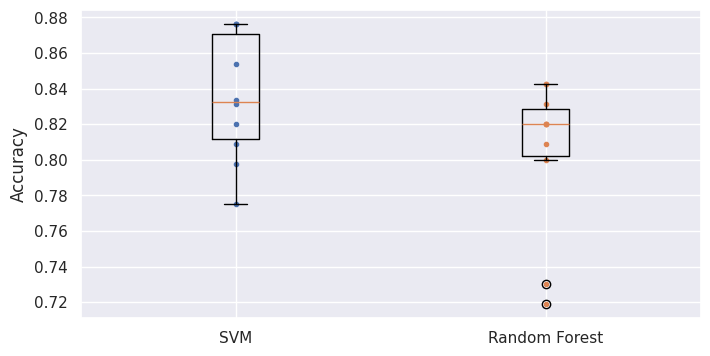

In [83]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

In [84]:
param_distribs = {
        'svc__kernel': ['linear', 'rbf'],
        'svc__C': loguniform(20, 200_000),
        'svc__gamma': expon(scale=1.0),
    }

svc_pipeline = Pipeline([("preprocessor", preprocessor), ("svc", SVC())])
rnd_search = RandomizedSearchCV(svc_pipeline,
                                param_distributions=param_distribs,
                                n_iter=10, cv=3,
                                scoring='accuracy',
                                verbose=2,
                                random_state=42)

rnd_search.fit(titanic_data, titanic_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END svc__C=629.7823295913721, svc__gamma=3.010121430917521, svc__kernel=linear; total time=  14.2s
[CV] END svc__C=629.7823295913721, svc__gamma=3.010121430917521, svc__kernel=linear; total time=   5.0s
[CV] END svc__C=629.7823295913721, svc__gamma=3.010121430917521, svc__kernel=linear; total time=  20.8s
[CV] END svc__C=26290.20646430022, svc__gamma=0.9084469696321253, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=26290.20646430022, svc__gamma=0.9084469696321253, svc__kernel=rbf; total time=   0.3s
[CV] END svc__C=26290.20646430022, svc__gamma=0.9084469696321253, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=84.14107900575871, svc__gamma=0.059838768608680676, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=84.14107900575871, svc__gamma=0.059838768608680676, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=84.14107900575871, svc__gamma=0.059838768608680676, svc__kernel=rbf; total time=   0.1s
[CV] END 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('columntransformer-1',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('name',
                                                                                                Pipeline(steps=[('functiontransformer',
                                                                                                                 FunctionTransformer(feature_names_out=<function title_name at 0x760375123250>,
                                                                                                                                     func=<function extract_title at 0x76036fd72f80>))]),
                                                                                                ['Name']),
                                                                                               ('ord',
                                                                                                P...
                                                               <__main__.DropColumnsTransformer object at 0x76036fddd360>)])),
                                             ('svc', SVC())]),
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x76036fc13b80>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x76036fdde050>,
                                        'svc__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='accuracy', verbose=2)

In [85]:
rnd_search.best_params_

{'svc__C': 113564.03940586244,
 'svc__gamma': 0.0007790692366582295,
 'svc__kernel': 'rbf'}

In [86]:
selector_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svc', SVC(C=rnd_search.best_params_["svc__C"],
                gamma=rnd_search.best_params_["svc__gamma"],
                kernel=rnd_search.best_params_["svc__kernel"])),
])

In [87]:
selector_rmses = cross_val_score(selector_pipeline,
                                  titanic_data,
                                  titanic_labels,
                                  scoring="accuracy",
                                  cv=3)
pd.Series(selector_rmses).describe()

count    3.000000
mean     0.821549
std      0.029353
min      0.787879
25%      0.811448
50%      0.835017
75%      0.838384
max      0.841751
dtype: float64

In [88]:
final_model = rnd_search.best_estimator_
final_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('name',
                                                                   Pipeline(steps=[('functiontransformer',
                                                                                    FunctionTransformer(feature_names_out=<function title_name at 0x760375123250>,
                                                                                                        func=<function extract_title at 0x76036fd72f80>))]),
                                                                   ['Name']),
                                                                  ('ord',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    O...
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['Sex',
                                                                    'Embarked',
                                                                    'traveling_category',
                                                                    'age_interval',
                                                                    'Title',
                                                                    'Cabin_First_Letter'])],
                                                    verbose_feature_names_out=False)),
                                 ('dropcolumnstransformer',
                                  <__main__.DropColumnsTransformer object at 0x76036fc23430>)])),
                ('svc',
                 SVC(C=113564.03940586244, gamma=0.0007790692366582295))])

In [89]:
rnd_search.best_estimator_.named_steps["svc"].feature_importances_

feature_importances = final_model["svc"].feature_importances_

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [90]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

NameError: name 'feature_importances' is not defined

In [91]:
final_predictions = final_model.predict(test_data)
final_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [92]:
# Convert final_predictions to a DataFrame
df = pd.DataFrame(final_predictions)

# Rename the columns
df.columns = ['Survived']

# Add a new column 'Id' with values from the index
df['PassengerId'] = test_data.index

# Reorder columns
df = df[['PassengerId', 'Survived']]

df.to_csv('predicted_results_att2.csv', index=False)